In [32]:
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import emachine as EM
from direct_info import direct_info

from data_processing import data_processing
import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)

## We will start by reading in a set of Protein structures with the given Protein ID "pfam_id"

In [21]:
# Read in Protein structure
data_path = '../protein/Pfam-A.full'
pfam_id = 'PF00001'
pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))

In [22]:
# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

In [23]:
# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

number of pdb structures: 298


In [24]:
# Print PDB array 
print(pdb)

[['PF00001' '704' 'AA2AR_HUMAN' ... 'A' '23' '288']
 ['PF00001' '704' 'AA2AR_HUMAN' ... 'A' '23' '288']
 ['PF00001' '704' 'AA2AR_HUMAN' ... 'A' '23' '288']
 ...
 ['PF00001' '55379' 'NPY1R_HUMAN' ... 'A' '57' '320']
 ['PF00001' '55379' 'NPY1R_HUMAN' ... 'A' '57' '320']
 ['PF00001' '55755' 'DRD2_HUMAN' ... 'A' '51' '426']]


Using the array of PDB structures above we will create a pandas database for easy data manipulation

In [25]:
# Create pandas dataframe for protein structure
df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_start',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
df.head()

,PF,seq,id,uniprot_start,uniprot_start,pdb_id,chain,pdb_start,pdb_end
0,PF00001,704,AA2AR_HUMAN,23,288,5IUB,A,23,288
1,PF00001,704,AA2AR_HUMAN,23,288,2YDV,A,23,288
2,PF00001,704,AA2AR_HUMAN,23,288,3RFM,A,23,288
3,PF00001,704,AA2AR_HUMAN,23,288,5IU4,A,23,288
4,PF00001,704,AA2AR_HUMAN,23,288,5K2D,A,23,288


Import contact map functions from newly defined tools python module

In [34]:
from ecc_tools import contact_map

In [27]:
ipdb = 0
print('seq:',int(pdb[ipdb,1]))

# data processing
s0,cols_removed = data_processing(data_path,pfam_id,ipdb,\
                gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)

ct = contact_map(pdb,ipdb,cols_removed)

seq: 704


Plot the contact Map of the imported Protein structure

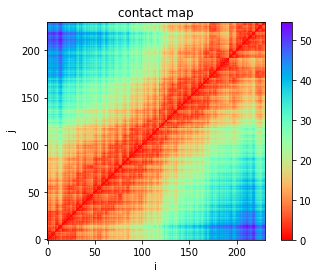

In [31]:
plt.title('contact map')
plt.imshow(ct,cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()

## Now we want to use Expectation Reflection to infer the "calculate the weights " 
  * Infer interactions between residues (R-part of ammino acid) in proteins from Multiple Sequence Alignment (MSA) data
  * More understanding required on meaning/interpretation of weights
  
We can start by definig some important values of our protein structures

In [47]:
# number of positions
n_var = s0.shape[1]
print("Number of residue positions:",n_var)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 
print("(Sanity Check) Indices of first and (",i1i2[0],") and last (",i1i2[-1],") positions")
# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

Number of residue positions: 230
Number of different amino acids at each position [ 2 11 12 10 10 16 11 12 18 18 19 19 20 19 18 19 18 17 18 16 11 11 14 14
  6 11 12 12 12 12 16 11 12 17 14 13 19 21 14 21 20 19 21 20 19 21 20 19
 21 21 15 11 20 12 18 20 13 11 19 20 13 14 17 15 13 10 12 15 12 11 10 12
  7  6 11 13 11 17 16  8 16 18 14 19 20 21 20 21 20 21 16 21 21 19 17 18
 18 16 11 11 11 12 10 15 12 11 11 17 16 11 12 20 15 18 21 21 19 20 21 21
 20 20 21 19 21 21 21 20 20 21 20 20 20 20 18 20 19 15 20 17 12 13 19 13
 13 12 12 12 11 10 10 10 14 11 10 15 19  8 14 17 17 10 18 18 19 19 20 19
 20 19 20 19 17 21 14 13 17 17 14  9 12 13 12 10 10 13 14 12 10  8 14 10
 17 16 10 18 19 14 17 20 21 20 21 21 21 21 21 21 20 21 21 19 20 21 14 20
 16 11 14 18 13 14 14 12 13  6  7 10  8  3]
(Sanity Check) Indices of first and ( [0 2] ) and last ( [3587 3590] ) positions
Total number of variables 3590


The above indices help to divide all the possible amino acids at different positions to binary choices which will be implemented wit 1 of K notation (OneHot Encoder)

In [54]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
s = onehot_encoder.fit_transform(s0)

In [55]:
mx_sum = mx.sum()
my_sum = mx.sum() #!!!! my_sum = mx_sum

w = np.zeros((mx_sum,my_sum))
h0 = np.zeros(my_sum)

### Apply Expectation Reflection
We can now apply expectation reflection to infer the connection between postion residues

In [56]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

In [ ]:
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1

#-------------------------------
# parallel
start_time = timeit.default_timer()
#res = Parallel(n_jobs = 32)(delayed(predict_w)\
res = Parallel(n_jobs = 8)(delayed(predict_w)\
        (s,i0,i1i2,niter_max=10,l2=100.0)\
        for i0 in range(n_var))

run_time = timeit.default_timer() - start_time
print('run time:',run_time)
## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
## python implementation or just wrong
#-------------------------------
for i0 in range(n_var):
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    h01 = res[i0][0]
    w1 = res[i0][1]

    h0[i1:i2] = h01
    w[:i1,i1:i2] = w1[:i1,:]
    w[i2:,i1:i2] = w1[i1:,:]

# make w symmetric
w = (w + w.T)/2.
di = direct_info(s0,w)
np.savetxt('%s/di.dat'%pfam_id,di,fmt='% 3.8f')
